In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


In [2]:
ratings = pd.read_csv('train.csv')
ratings.head()

,userID,movieID,rating
0,4490,2109,4
1,5839,3471,4
2,5382,150,3
3,1262,1237,5
4,6005,2273,4


In [3]:
ratings.shape

(990209, 3)

In [4]:
global_mean = ratings.rating.mean()

user_means = ratings.groupby('userID').rating.mean()
movie_means = ratings.groupby('movieID').rating.mean()

ratings = ratings.merge(pd.DataFrame(user_means), on='userID', how='left')
ratings = ratings.merge(pd.DataFrame(movie_means), on='movieID', how='left')
ratings.columns = ['userID', 'movieID', 'rating', 'user_mean', 'movie_mean']

ratings['baseline'] = global_mean + (ratings.user_mean - global_mean) + (ratings.movie_mean - global_mean)
ratings['deviation'] = ratings.rating - ratings.baseline

pivot1= ratings.pivot(index="movieID", columns= "userID", values="rating")
scaled_df = pivot1 - pivot1.mean(axis=1).values.reshape(-1, 1)
scaled_df.fillna(0, inplace=True)
similarities = cosine_similarity(scaled_df,scaled_df)
similarities_df = pd.DataFrame(similarities,columns=pivot1.index,index=pivot1.index)

In [171]:
def predict_rating(user_id, movie_id):
    top10_movies = similarities_df.loc[movie_id,ratings.loc[ratings.userID == user_id].movieID.to_list()].sort_values(ascending=False)[1:11].index.to_list()
    similarities = similarities_df.loc[movie_id,ratings.loc[ratings.userID == user_id].movieID.to_list()].sort_values(ascending=False)[1:11].to_list()
    deviations = []
    for i in top10_movies:
        deviations.append(ratings.loc[(ratings.userID == user_id) & (ratings.movieID == i)].deviation.values[0]) 
    
    weighted_deviations = 0
    for i in range(len(top10_movies)):
        weighted_deviations += similarities[i] * deviations[i]
    
    baseline_rate = global_mean + (ratings[(ratings.userID == user_id)].user_mean.values[0] - global_mean) + (ratings[(ratings.movieID == movie_id)].movie_mean.values[0] - global_mean)
    
    predicted_rating = baseline_rate + (weighted_deviations / np.sum(similarities))

    return predicted_rating

In [113]:
test_no_labels = pd.read_csv("test_without_labels.csv")
test_no_labels.head()

,IDs
0,629_2683
1,601_904
2,5673_3717
3,5616_1721
4,1099_3697


In [114]:
test_no_labels["userID"] = test_no_labels.IDs.str.split('_').str[0].astype(int)
test_no_labels["movieID"] = test_no_labels.IDs.str.split('_').str[1].astype(int)
test_no_labels.head()

,IDs,userID,movieID
0,629_2683,629,2683
1,601_904,601,904
2,5673_3717,5673,3717
3,5616_1721,5616,1721
4,1099_3697,1099,3697


In [115]:
test_weighted = test_no_labels.drop("IDs",axis=1)

In [132]:
preds = []
for user,movie in test_weighted.itertuples(index=False):
    preds.append(predict_rating(user,movie))

C:\Users\Burak\AppData\Local\Temp\ipykernel_18572\1689546358.py:15: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = baseline_rate + (weighted_deviations / np.sum(similarities))
C:\Users\Burak\AppData\Local\Temp\ipykernel_18572\1689546358.py:15: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = baseline_rate + (weighted_deviations / np.sum(similarities))
C:\Users\Burak\AppData\Local\Temp\ipykernel_18572\1689546358.py:15: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = baseline_rate + (weighted_deviations / np.sum(similarities))


In [133]:
for i in range(len(preds)): 
    if preds[i] > 5:
        preds[i] = 5
    elif preds[i] < 1:
        preds[i] = 1

In [134]:
len(preds)

9999

In [137]:
for i in range(len(preds)): 
    if not preds[i] <= 5 or not preds[i] >= 1:
        preds[i] = global_mean

In [138]:
sum(preds)/len(preds)

3.609687940993474

In [139]:
test_no_labels["rating"] = preds
test_no_labels.drop(columns=["userID","movieID"],axis=1,inplace=True)
test_no_labels.to_csv("result_weighted_v3_3004.csv", index=False)

In [7]:
from sklearn.neighbors import NearestNeighbors

In [71]:
def predict_rating(user_id, movie_id):
    k = 25
    filtered = scaled_df[(scaled_df.loc[:,user_id] != 0) & (scaled_df.index != movie_id)]
    if len(filtered) < k:
        k = len(filtered)
    nn = NearestNeighbors(n_neighbors=k, metric="cosine")
    nn.fit(filtered)
    distances,indices = nn.kneighbors(scaled_df.loc[[movie_id]])
    top25_movies = filtered.iloc[indices[0].tolist()].index
    distances = distances[0].tolist()
    similarities = []
    for i in distances:
        similarities.append(1 - i)
    
    deviations = []
    for i in top25_movies:
        deviations.append(ratings.loc[(ratings.userID == user_id) & (ratings.movieID == i)].rating.values[0] - (ratings[(ratings.userID == user_id)].user_mean.values[0] + ratings[(ratings.movieID == i)].movie_mean.values[0]  - global_mean))
        
    weighted_deviations = 0
    for i in range(len(top25_movies)):
        weighted_deviations += similarities[i] * deviations[i]
    
    baseline_rate = global_mean + (ratings[(ratings.userID == user_id)].user_mean.values[0] - global_mean) + (ratings[(ratings.movieID == movie_id)].movie_mean.values[0] - global_mean)
    
    predicted_rating = baseline_rate + (weighted_deviations / np.sum(similarities))

    return predicted_rating

In [72]:
test = ratings[:10000]
test = test[["userID","movieID"]]

preds = []
for user,movie in test.itertuples(index=False):
    preds.append(predict_rating(user,movie))

In [73]:
for i in range(len(preds)): 
    if preds[i] > 5:
        preds[i] = 5
    elif preds[i] < 1:
        preds[i] = 1
        
for i in range(len(preds)): 
    if not preds[i] <= 5 or not preds[i] >= 1:
        preds[i] = global_mean

In [74]:
mean_squared_error(preds,ratings[:10000].rating.to_list(),squared=False)

0.7738419878000423

In [75]:
test_no_labels = pd.read_csv("test_without_labels.csv")
test_no_labels["userID"] = test_no_labels.IDs.str.split('_').str[0].astype(int)
test_no_labels["movieID"] = test_no_labels.IDs.str.split('_').str[1].astype(int)
test_weighted = test_no_labels.drop("IDs",axis=1)
preds = []
for user,movie in test_weighted.itertuples(index=False):
    preds.append(predict_rating(user,movie))

In [76]:
len(preds)

9999

In [78]:
for i in range(len(preds)): 
    if preds[i] > 5:
        preds[i] = 5
    elif preds[i] < 1:
        preds[i] = 1
        
for i in range(len(preds)): 
    if not preds[i] <= 5 or not preds[i] >= 1:
        preds[i] = global_mean

In [79]:
sum(preds)/len(preds)

3.606783083880396

In [80]:
test_no_labels["rating"] = preds
test_no_labels.drop(columns=["userID","movieID"],axis=1,inplace=True)
test_no_labels.to_csv("result_weighted_LAST3.csv", index=False)

# BEST RMSE SCORE WITH "result_weighted_LAST3.csv"

In [82]:
def predict_rating(user_id, movie_id):
    k = 5
    filtered = scaled_df[(scaled_df.loc[:,user_id] != 0) & (scaled_df.index != movie_id)]
    if len(filtered) < k:
        k = len(filtered)
    nn = NearestNeighbors(n_neighbors=k, metric="cosine")
    nn.fit(filtered)
    distances,indices = nn.kneighbors(scaled_df.loc[[movie_id]])
    top25_movies = filtered.iloc[indices[0].tolist()].index
    distances = distances[0].tolist()
    similarities = []
    for i in distances:
        similarities.append(1 - i)
    
    deviations = []
    for i in top25_movies:
        deviations.append(ratings.loc[(ratings.userID == user_id) & (ratings.movieID == i)].rating.values[0] - (ratings[(ratings.userID == user_id)].user_mean.values[0] + ratings[(ratings.movieID == i)].movie_mean.values[0]  - global_mean))
        
    weighted_deviations = 0
    for i in range(len(top25_movies)):
        weighted_deviations += similarities[i] * deviations[i]
    
    baseline_rate = global_mean + (ratings[(ratings.userID == user_id)].user_mean.values[0] - global_mean) + (ratings[(ratings.movieID == movie_id)].movie_mean.values[0] - global_mean)
    
    predicted_rating = baseline_rate + (weighted_deviations / np.sum(similarities))

    return predicted_rating

In [83]:
test = ratings[:2000]
test = test[["userID","movieID"]]

preds = []
for user,movie in test.itertuples(index=False):
    preds.append(predict_rating(user,movie))

In [84]:
for i in range(len(preds)): 
    if preds[i] > 5:
        preds[i] = 5
    elif preds[i] < 1:
        preds[i] = 1
        
for i in range(len(preds)): 
    if not preds[i] <= 5 or not preds[i] >= 1:
        preds[i] = global_mean

In [85]:
mean_squared_error(preds,ratings[:2000].rating.to_list(),squared=False)

0.8065818715790588

In [86]:
def predict_rating(user_id, movie_id):
    k = 10
    filtered = scaled_df[(scaled_df.loc[:,user_id] != 0) & (scaled_df.index != movie_id)]
    if len(filtered) < k:
        k = len(filtered)
    nn = NearestNeighbors(n_neighbors=k, metric="cosine")
    nn.fit(filtered)
    distances,indices = nn.kneighbors(scaled_df.loc[[movie_id]])
    top25_movies = filtered.iloc[indices[0].tolist()].index
    distances = distances[0].tolist()
    similarities = []
    for i in distances:
        similarities.append(1 - i)
    
    deviations = []
    for i in top25_movies:
        deviations.append(ratings.loc[(ratings.userID == user_id) & (ratings.movieID == i)].rating.values[0] - (ratings[(ratings.userID == user_id)].user_mean.values[0] + ratings[(ratings.movieID == i)].movie_mean.values[0]  - global_mean))
        
    weighted_deviations = 0
    for i in range(len(top25_movies)):
        weighted_deviations += similarities[i] * deviations[i]
    
    baseline_rate = global_mean + (ratings[(ratings.userID == user_id)].user_mean.values[0] - global_mean) + (ratings[(ratings.movieID == movie_id)].movie_mean.values[0] - global_mean)
    
    predicted_rating = baseline_rate + (weighted_deviations / np.sum(similarities))

    return predicted_rating

In [87]:
test = ratings[:2000]
test = test[["userID","movieID"]]

preds = []
for user,movie in test.itertuples(index=False):
    preds.append(predict_rating(user,movie))

In [88]:
for i in range(len(preds)): 
    if preds[i] > 5:
        preds[i] = 5
    elif preds[i] < 1:
        preds[i] = 1
        
for i in range(len(preds)): 
    if not preds[i] <= 5 or not preds[i] >= 1:
        preds[i] = global_mean

In [89]:
mean_squared_error(preds,ratings[:2000].rating.to_list(),squared=False)

0.7801258569224209

In [90]:
def predict_rating(user_id, movie_id):
    k = 15
    filtered = scaled_df[(scaled_df.loc[:,user_id] != 0) & (scaled_df.index != movie_id)]
    if len(filtered) < k:
        k = len(filtered)
    nn = NearestNeighbors(n_neighbors=k, metric="cosine")
    nn.fit(filtered)
    distances,indices = nn.kneighbors(scaled_df.loc[[movie_id]])
    top25_movies = filtered.iloc[indices[0].tolist()].index
    distances = distances[0].tolist()
    similarities = []
    for i in distances:
        similarities.append(1 - i)
    
    deviations = []
    for i in top25_movies:
        deviations.append(ratings.loc[(ratings.userID == user_id) & (ratings.movieID == i)].rating.values[0] - (ratings[(ratings.userID == user_id)].user_mean.values[0] + ratings[(ratings.movieID == i)].movie_mean.values[0]  - global_mean))
        
    weighted_deviations = 0
    for i in range(len(top25_movies)):
        weighted_deviations += similarities[i] * deviations[i]
    
    baseline_rate = global_mean + (ratings[(ratings.userID == user_id)].user_mean.values[0] - global_mean) + (ratings[(ratings.movieID == movie_id)].movie_mean.values[0] - global_mean)
    
    predicted_rating = baseline_rate + (weighted_deviations / np.sum(similarities))

    return predicted_rating

In [91]:
test = ratings[:2000]
test = test[["userID","movieID"]]

preds = []
for user,movie in test.itertuples(index=False):
    preds.append(predict_rating(user,movie))

In [92]:
for i in range(len(preds)): 
    if preds[i] > 5:
        preds[i] = 5
    elif preds[i] < 1:
        preds[i] = 1
        
for i in range(len(preds)): 
    if not preds[i] <= 5 or not preds[i] >= 1:
        preds[i] = global_mean

In [93]:
mean_squared_error(preds,ratings[:2000].rating.to_list(),squared=False)

0.7776675721012835

In [94]:
def predict_rating(user_id, movie_id):
    k = 20
    filtered = scaled_df[(scaled_df.loc[:,user_id] != 0) & (scaled_df.index != movie_id)]
    if len(filtered) < k:
        k = len(filtered)
    nn = NearestNeighbors(n_neighbors=k, metric="cosine")
    nn.fit(filtered)
    distances,indices = nn.kneighbors(scaled_df.loc[[movie_id]])
    top25_movies = filtered.iloc[indices[0].tolist()].index
    distances = distances[0].tolist()
    similarities = []
    for i in distances:
        similarities.append(1 - i)
    
    deviations = []
    for i in top25_movies:
        deviations.append(ratings.loc[(ratings.userID == user_id) & (ratings.movieID == i)].rating.values[0] - (ratings[(ratings.userID == user_id)].user_mean.values[0] + ratings[(ratings.movieID == i)].movie_mean.values[0]  - global_mean))
        
    weighted_deviations = 0
    for i in range(len(top25_movies)):
        weighted_deviations += similarities[i] * deviations[i]
    
    baseline_rate = global_mean + (ratings[(ratings.userID == user_id)].user_mean.values[0] - global_mean) + (ratings[(ratings.movieID == movie_id)].movie_mean.values[0] - global_mean)
    
    predicted_rating = baseline_rate + (weighted_deviations / np.sum(similarities))

    return predicted_rating

In [95]:
test = ratings[:2000]
test = test[["userID","movieID"]]

preds = []
for user,movie in test.itertuples(index=False):
    preds.append(predict_rating(user,movie))

In [96]:
for i in range(len(preds)): 
    if preds[i] > 5:
        preds[i] = 5
    elif preds[i] < 1:
        preds[i] = 1
        
for i in range(len(preds)): 
    if not preds[i] <= 5 or not preds[i] >= 1:
        preds[i] = global_mean

In [97]:
mean_squared_error(preds,ratings[:2000].rating.to_list(),squared=False)

0.7751197686587386

In [98]:
def predict_rating(user_id, movie_id):
    k = 25
    filtered = scaled_df[(scaled_df.loc[:,user_id] != 0) & (scaled_df.index != movie_id)]
    if len(filtered) < k:
        k = len(filtered)
    nn = NearestNeighbors(n_neighbors=k, metric="cosine")
    nn.fit(filtered)
    distances,indices = nn.kneighbors(scaled_df.loc[[movie_id]])
    top25_movies = filtered.iloc[indices[0].tolist()].index
    distances = distances[0].tolist()
    similarities = []
    for i in distances:
        similarities.append(1 - i)
    
    deviations = []
    for i in top25_movies:
        deviations.append(ratings.loc[(ratings.userID == user_id) & (ratings.movieID == i)].rating.values[0] - (ratings[(ratings.userID == user_id)].user_mean.values[0] + ratings[(ratings.movieID == i)].movie_mean.values[0]  - global_mean))
        
    weighted_deviations = 0
    for i in range(len(top25_movies)):
        weighted_deviations += similarities[i] * deviations[i]
    
    baseline_rate = global_mean + (ratings[(ratings.userID == user_id)].user_mean.values[0] - global_mean) + (ratings[(ratings.movieID == movie_id)].movie_mean.values[0] - global_mean)
    
    predicted_rating = baseline_rate + (weighted_deviations / np.sum(similarities))

    return predicted_rating

In [99]:
test = ratings[:2000]
test = test[["userID","movieID"]]

preds = []
for user,movie in test.itertuples(index=False):
    preds.append(predict_rating(user,movie))

In [100]:
for i in range(len(preds)): 
    if preds[i] > 5:
        preds[i] = 5
    elif preds[i] < 1:
        preds[i] = 1
        
for i in range(len(preds)): 
    if not preds[i] <= 5 or not preds[i] >= 1:
        preds[i] = global_mean

In [101]:
mean_squared_error(preds,ratings[:2000].rating.to_list(),squared=False)

0.7750794894795131

In [102]:
def predict_rating(user_id, movie_id):
    k = 30
    filtered = scaled_df[(scaled_df.loc[:,user_id] != 0) & (scaled_df.index != movie_id)]
    if len(filtered) < k:
        k = len(filtered)
    nn = NearestNeighbors(n_neighbors=k, metric="cosine")
    nn.fit(filtered)
    distances,indices = nn.kneighbors(scaled_df.loc[[movie_id]])
    top25_movies = filtered.iloc[indices[0].tolist()].index
    distances = distances[0].tolist()
    similarities = []
    for i in distances:
        similarities.append(1 - i)
    
    deviations = []
    for i in top25_movies:
        deviations.append(ratings.loc[(ratings.userID == user_id) & (ratings.movieID == i)].rating.values[0] - (ratings[(ratings.userID == user_id)].user_mean.values[0] + ratings[(ratings.movieID == i)].movie_mean.values[0]  - global_mean))
        
    weighted_deviations = 0
    for i in range(len(top25_movies)):
        weighted_deviations += similarities[i] * deviations[i]
    
    baseline_rate = global_mean + (ratings[(ratings.userID == user_id)].user_mean.values[0] - global_mean) + (ratings[(ratings.movieID == movie_id)].movie_mean.values[0] - global_mean)
    
    predicted_rating = baseline_rate + (weighted_deviations / np.sum(similarities))

    return predicted_rating

In [103]:
test = ratings[:2000]
test = test[["userID","movieID"]]

preds = []
for user,movie in test.itertuples(index=False):
    preds.append(predict_rating(user,movie))

In [104]:
for i in range(len(preds)): 
    if preds[i] > 5:
        preds[i] = 5
    elif preds[i] < 1:
        preds[i] = 1
        
for i in range(len(preds)): 
    if not preds[i] <= 5 or not preds[i] >= 1:
        preds[i] = global_mean

In [105]:
mean_squared_error(preds,ratings[:2000].rating.to_list(),squared=False)

0.7735457189761383

In [106]:
def predict_rating(user_id, movie_id):
    k = 35
    filtered = scaled_df[(scaled_df.loc[:,user_id] != 0) & (scaled_df.index != movie_id)]
    if len(filtered) < k:
        k = len(filtered)
    nn = NearestNeighbors(n_neighbors=k, metric="cosine")
    nn.fit(filtered)
    distances,indices = nn.kneighbors(scaled_df.loc[[movie_id]])
    top25_movies = filtered.iloc[indices[0].tolist()].index
    distances = distances[0].tolist()
    similarities = []
    for i in distances:
        similarities.append(1 - i)
    
    deviations = []
    for i in top25_movies:
        deviations.append(ratings.loc[(ratings.userID == user_id) & (ratings.movieID == i)].rating.values[0] - (ratings[(ratings.userID == user_id)].user_mean.values[0] + ratings[(ratings.movieID == i)].movie_mean.values[0]  - global_mean))
        
    weighted_deviations = 0
    for i in range(len(top25_movies)):
        weighted_deviations += similarities[i] * deviations[i]
    
    baseline_rate = global_mean + (ratings[(ratings.userID == user_id)].user_mean.values[0] - global_mean) + (ratings[(ratings.movieID == movie_id)].movie_mean.values[0] - global_mean)
    
    predicted_rating = baseline_rate + (weighted_deviations / np.sum(similarities))

    return predicted_rating

In [107]:
test = ratings[:2000]
test = test[["userID","movieID"]]

preds = []
for user,movie in test.itertuples(index=False):
    preds.append(predict_rating(user,movie))

In [108]:
for i in range(len(preds)): 
    if preds[i] > 5:
        preds[i] = 5
    elif preds[i] < 1:
        preds[i] = 1
        
for i in range(len(preds)): 
    if not preds[i] <= 5 or not preds[i] >= 1:
        preds[i] = global_mean

In [109]:
mean_squared_error(preds,ratings[:2000].rating.to_list(),squared=False)

0.774095289535659

In [110]:
k_ = [5, 10, 15, 20, 25, 30, 35]
scores = [0.8065818715790588, 0.7801258569224209, 0.7776675721012835,0.7751197686587386,0.7750794894795131,0.7735457189761383, 0.774095289535659]

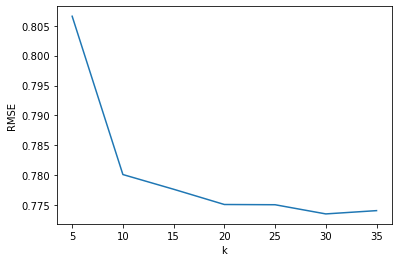

In [111]:
import matplotlib.pyplot as plt

plt.plot(k_, scores)
plt.xlabel("k")
plt.ylabel("RMSE")
plt.show();

In [112]:
def predict_rating(user_id, movie_id):
    k = 30
    filtered = scaled_df[(scaled_df.loc[:,user_id] != 0) & (scaled_df.index != movie_id)]
    if len(filtered) < k:
        k = len(filtered)
    nn = NearestNeighbors(n_neighbors=k, metric="cosine")
    nn.fit(filtered)
    distances,indices = nn.kneighbors(scaled_df.loc[[movie_id]])
    top25_movies = filtered.iloc[indices[0].tolist()].index
    distances = distances[0].tolist()
    similarities = []
    for i in distances:
        similarities.append(1 - i)
    
    deviations = []
    for i in top25_movies:
        deviations.append(ratings.loc[(ratings.userID == user_id) & (ratings.movieID == i)].rating.values[0] - (ratings[(ratings.userID == user_id)].user_mean.values[0] + ratings[(ratings.movieID == i)].movie_mean.values[0]  - global_mean))
        
    weighted_deviations = 0
    for i in range(len(top25_movies)):
        weighted_deviations += similarities[i] * deviations[i]
    
    baseline_rate = global_mean + (ratings[(ratings.userID == user_id)].user_mean.values[0] - global_mean) + (ratings[(ratings.movieID == movie_id)].movie_mean.values[0] - global_mean)
    
    predicted_rating = baseline_rate + (weighted_deviations / np.sum(similarities))
    if predicted_rating > 5:
        predicted_rating = 5
    elif predicted_rating < 1:
        predicted_rating = 1
    if not predicted_rating <= 5 or not predicted_rating >= 1:
        predicted_rating = ratings[(ratings.userID == user_id)].user_mean.values[0]

    return predicted_rating

In [114]:
preds = []
for user,movie in test_weighted.itertuples(index=False):
    preds.append(predict_rating(user,movie))

In [115]:
sum(preds)/len(preds)

3.6063004112365715

In [117]:
test_no_labels["rating"] = preds
test_no_labels.to_csv("result_weighted_LAST2.csv", index=False)

In [122]:
def predict_rating(user_id, movie_id):
    k = 30
    filtered = scaled_df[(scaled_df.loc[:,user_id] != 0) & (scaled_df.index != movie_id)]
    if len(filtered) < k:
        k = len(filtered)
    nn = NearestNeighbors(n_neighbors=k, metric="cosine")
    nn.fit(filtered)
    distances,indices = nn.kneighbors(scaled_df.loc[[movie_id]])
    top25_movies = filtered.iloc[indices[0].tolist()].index
    distances = distances[0].tolist()
    similarities = []
    for i in distances:
        similarities.append(1 - i)
    
    deviations = []
    for i in top25_movies:
        deviations.append(ratings.loc[(ratings.userID == user_id) & (ratings.movieID == i)].rating.values[0] - (ratings[(ratings.userID == user_id)].user_mean.values[0] + ratings[(ratings.movieID == i)].movie_mean.values[0]  - global_mean))
        
    weighted_deviations = 0
    for i in range(len(top25_movies)):
        weighted_deviations += similarities[i] * deviations[i]
    
    baseline_rate = global_mean + (ratings[(ratings.userID == user_id)].user_mean.values[0] - global_mean) + (ratings[(ratings.movieID == movie_id)].movie_mean.values[0] - global_mean)
    
    if np.sum(similarities) != 0:
        predicted_rating = baseline_rate + (weighted_deviations / np.sum(similarities))
    else:
        predicted_rating = baseline_rate
        
    if predicted_rating > 5:
        predicted_rating = 5
    elif predicted_rating < 1:
        predicted_rating = 1

    return predicted_rating

In [123]:
preds = []
for user,movie in test_weighted.itertuples(index=False):
    preds.append(predict_rating(user,movie))

In [124]:
sum(preds)/len(preds)

3.6062888793670926

In [125]:
test_no_labels["rating"] = preds
test_no_labels.to_csv("result_weighted_LAST.csv", index=False)